# Coin Gecko LSTM for Crypto Currency Demo

In [2]:
!pip install requests

## Load Data

In [63]:
from google.colab import userdata # Used for Secrets
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timezone

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Replace with your actual API key
api_key = userdata.get('coin_gecko')

### Test Public Endpoint is Available

In [8]:
# API endpoint for ping
url = 'https://api.coingecko.com/api/v3/ping'

# Making the GET request
response = requests.get(url)

# Checking the status code
if response.status_code == 200:
    # If the request was successful, print the response content
    print(response.json())
else:
    # If there was an error, print the status code and reason
    print(f"Error: {response.status_code} - {response.reason}")

{'gecko_says': '(V3) To the Moon!'}


### Get availabe CryptoCurrencies

In [17]:
# Get Crypto Coins List
url = 'https://api.coingecko.com/api/v3/coins/list'

# Make the GET request
response = requests.get(url)
# Checking the status code
if response.status_code == 200:
    print('Success')
else:
    print(f"Error: {response.status_code} - {response.reason}")

crypto_coins = response.json()

crypto_coins = pd.DataFrame(crypto_coins) # Let's make it a DataFrame
crypto_coins.head()

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0-knowledge-network,0kn,0 Knowledge Network
3,0-mee,ome,O-MEE
4,0vix-protocol,vix,0VIX Protocol


In [21]:
# Lets work with Bitcoin
crypto_coins[crypto_coins['symbol'] == 'btc']

,id,symbol,name
1353,bitcoin,btc,Bitcoin


### Grab Historical Data

In [58]:
date_str = '12/7/2023'
date_format = '%m/%d/%Y'

# Convert the date string to a datetime object
date_object = datetime.strptime(date_str, date_format)

# Convert the datetime object to UNIX timestamp
unix_timestamp = int(date_object.replace(tzinfo=timezone.utc).timestamp())

In [59]:
coin_name = crypto_coins[crypto_coins['symbol'] == 'btc'].id.iloc[0]
url = f'https://api.coingecko.com/api/v3/coins/{coin_name}/market_chart/range'

date_start = '9/7/2023'
date_end = '12/7/2023'
date_format = '%m/%d/%Y'

date_start = datetime.strptime(date_start, date_format)
date_end = datetime.strptime(date_end, date_format)

# Make start and end date UNIX timestamp
date_start = int(date_start.replace(tzinfo=timezone.utc).timestamp())
date_end = int(date_end.replace(tzinfo=timezone.utc).timestamp())

params = {
    'vs_currency': 'usd', # Using US Dollar
    'from': date_start, # Date ranges need to be in UNIX Timestamp
    'to': date_end,
    'precision': 3 # Specifiy how many decimal points of precision
}

headers = {
    'accept': 'application/json'
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Checking the status code
if response.status_code == 200:
    print('Success')
else:
    print(f"Error: {response.status_code} - {response.reason}")

Success


In [60]:
# Consolidate Data
data = response.json()

# Temporarily save data in separate dataframes
df_prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
df_market_caps = pd.DataFrame(data['market_caps'], columns=['timestamp', 'market_cap'])
df_total_volumes = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'total_volume'])

# Merge DataFrames on the 'timestamp' column
crypto_data = pd.merge(df_prices, df_market_caps, on='timestamp')
crypto_data = pd.merge(crypto_data, df_total_volumes, on='timestamp')

# Reassign timestamp as datetime
crypto_data['timestamp'] = pd.to_datetime(crypto_data['timestamp'],unit='ms')
crypto_data = crypto_data.set_index('timestamp')

## Plot Market Trends

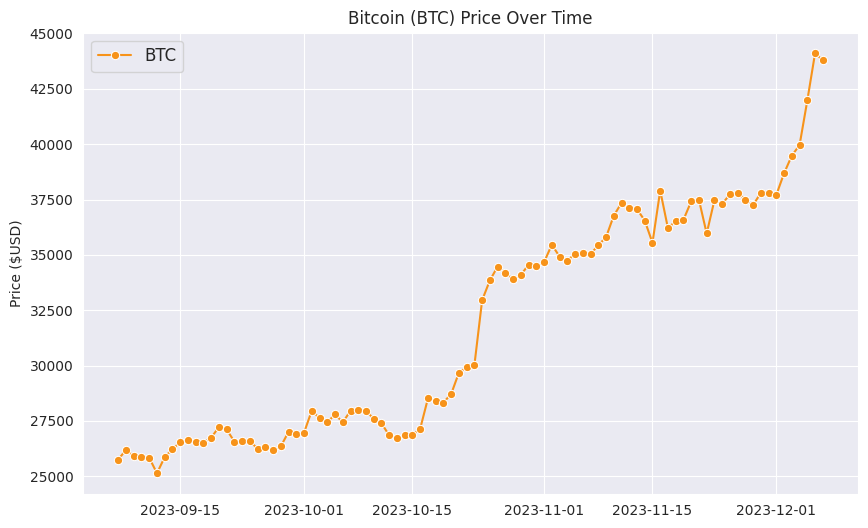

In [61]:
sns.set_style("darkgrid")

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='price', data=crypto_data, marker='o', color='#F7931A')

# Set plot labels and title
plt.xlabel('')
plt.ylabel('Price ($USD)')
plt.title('Bitcoin (BTC) Price Over Time')

# Add legend
plt.legend(['BTC'], loc='upper left', fontsize=12)

# Show the plot
plt.show()

## LSTM Model

In [64]:
target_variable = 'price'
target_series = crypto_data[target_variable].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
target_scaled = scaler.fit_transform(target_series)

In [65]:
# Function to create input sequences and labels
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence length
sequence_length = 3  # You can adjust this based on your preference

# Create sequences and labels
X, y = create_sequences(target_scaled, sequence_length)

In [66]:
# Use the final 20% of the data for testing
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [67]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions to the original scale
predictions_original = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)

Epoch 1/50
71/71 [==============================] - 2s 13ms/step - loss: 0.0571
Epoch 2/50
71/71 [==============================] - 1s 14ms/step - loss: 0.0102
Epoch 3/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 5/50
71/71 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 6/50
71/71 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 7/50
71/71 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 8/50
71/71 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 9/50
71/71 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 10/50
71/71 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 11/50
71/71 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 12/50
71/71 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 13/50
71/71 [============================

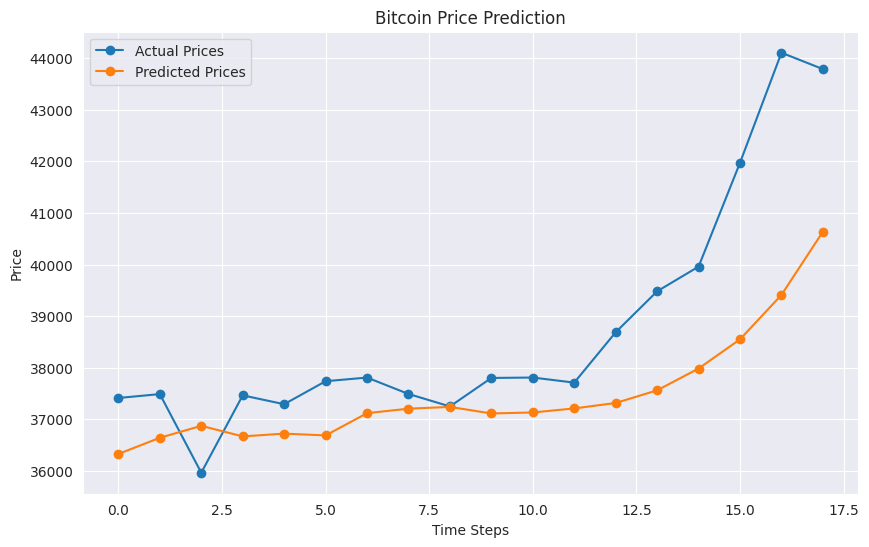

In [68]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Prices', marker='o')
plt.plot(predictions_original, label='Predicted Prices', marker='o')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()